# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:09, 20.2MB/s]                            
SVHN Testing Set: 64.3MB [00:04, 14.8MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

In [5]:
type(trainset)

dict

In [6]:
trainset.keys()

dict_keys(['__globals__', 'X', '__header__', '__version__', 'y'])

In [7]:
trainset['X'].shape

(32, 32, 3, 73257)

In [8]:
trainset['y'].shape

(73257, 1)

In [9]:
trainset['y'][0][0]

1

In [10]:
testset['X'].shape

(32, 32, 3, 26032)

In [11]:
testset['y'].shape

(26032, 1)

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

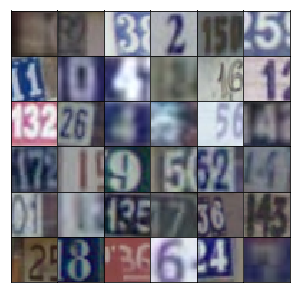

In [12]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [13]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [14]:
trainset['X'][:,:,0,0]

array([[ 33,  15,  15, ...,  72,  82,  89],
       [ 28,  14,  14, ...,  40,  67,  83],
       [ 40,  18,  16, ...,  23,  35,  72],
       ..., 
       [ 86,  87,  82, ..., 104, 104, 103],
       [ 84,  86,  82, ..., 110, 106, 106],
       [ 85,  89,  85, ..., 111, 109, 103]], dtype=uint8)

In [15]:
trainset['X'][:,:,:,0].min()

12

In [16]:
trainset['X'][:,:,:,0].max()

114

In [17]:
scale(trainset['X'][:,:,:,0])

array([[[-0.82716049, -0.85185185, -0.78600823],
        [-0.97530864, -0.90946502, -0.94238683],
        [-0.97530864, -0.95884774, -0.94238683],
        ..., 
        [-0.50617284, -0.56378601, -0.63786008],
        [-0.42386831, -0.46502058, -0.62962963],
        [-0.36625514, -0.44855967, -0.61316872]],

       [[-0.86831276, -0.77777778, -0.81069959],
        [-0.98353909, -0.89300412, -0.91769547],
        [-0.98353909, -0.93415638, -0.95884774],
        ..., 
        [-0.76954733, -0.77777778, -0.6872428 ],
        [-0.5473251 , -0.62139918, -0.67078189],
        [-0.41563786, -0.45679012, -0.60493827]],

       [[-0.76954733, -0.76131687, -0.78600823],
        [-0.95061728, -0.92592593, -0.88477366],
        [-0.96707819, -0.95884774, -0.90946502],
        ..., 
        [-0.90946502, -0.8600823 , -0.72839506],
        [-0.81069959, -0.75308642, -0.73662551],
        [-0.50617284, -0.5308642 , -0.66255144]],

       ..., 
       [[-0.3909465 , -0.43209877, -0.48148148],
        

In [18]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [19]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [20]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, [-1, 4, 4, 512])
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1) # leaky ReLU
        # 4 * 4 * 512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8 * 8 * 256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16 * 16 * 128

        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding="same")
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [21]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(alpha * x1, x1)
        # 16 * 16 * 64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8 * 8 * 128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4 * 4 * 256

        flatten = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [22]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [24]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [25]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [26]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [27]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 0.2712... Generator Loss: 2.0712
Epoch 1/25... Discriminator Loss: 0.3943... Generator Loss: 3.3987
Epoch 1/25... Discriminator Loss: 0.4325... Generator Loss: 2.2935
Epoch 1/25... Discriminator Loss: 0.3357... Generator Loss: 2.2285
Epoch 1/25... Discriminator Loss: 0.4429... Generator Loss: 5.9922
Epoch 1/25... Discriminator Loss: 0.7617... Generator Loss: 1.4558
Epoch 1/25... Discriminator Loss: 0.8348... Generator Loss: 0.7738
Epoch 1/25... Discriminator Loss: 0.7765... Generator Loss: 1.7896
Epoch 1/25... Discriminator Loss: 0.6689... Generator Loss: 1.5995
Epoch 1/25... Discriminator Loss: 0.5929... Generator Loss: 1.8551


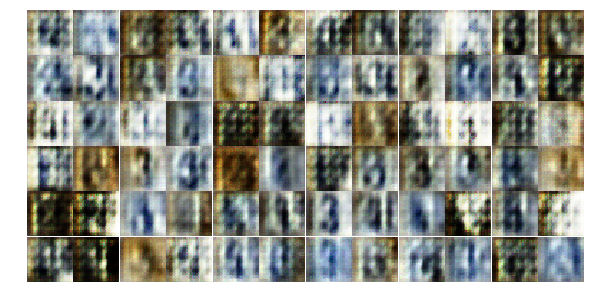

Epoch 1/25... Discriminator Loss: 0.6033... Generator Loss: 2.1081
Epoch 2/25... Discriminator Loss: 1.9663... Generator Loss: 0.2500
Epoch 2/25... Discriminator Loss: 0.9737... Generator Loss: 1.1141
Epoch 2/25... Discriminator Loss: 0.6668... Generator Loss: 1.4956
Epoch 2/25... Discriminator Loss: 0.9674... Generator Loss: 1.3479
Epoch 2/25... Discriminator Loss: 1.0338... Generator Loss: 0.8123
Epoch 2/25... Discriminator Loss: 0.7491... Generator Loss: 1.6621
Epoch 2/25... Discriminator Loss: 1.1067... Generator Loss: 0.8332
Epoch 2/25... Discriminator Loss: 1.0769... Generator Loss: 1.1742
Epoch 2/25... Discriminator Loss: 0.9031... Generator Loss: 1.4173


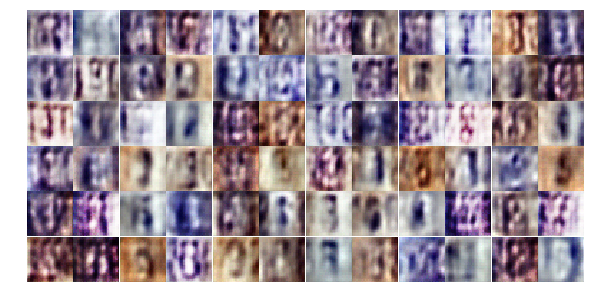

Epoch 2/25... Discriminator Loss: 0.9828... Generator Loss: 1.0020
Epoch 2/25... Discriminator Loss: 0.9382... Generator Loss: 1.2103
Epoch 3/25... Discriminator Loss: 0.8339... Generator Loss: 2.0528
Epoch 3/25... Discriminator Loss: 0.8263... Generator Loss: 1.6626
Epoch 3/25... Discriminator Loss: 0.7156... Generator Loss: 1.2869
Epoch 3/25... Discriminator Loss: 0.9416... Generator Loss: 0.7411
Epoch 3/25... Discriminator Loss: 0.7191... Generator Loss: 1.1639
Epoch 3/25... Discriminator Loss: 0.5459... Generator Loss: 1.2155
Epoch 3/25... Discriminator Loss: 0.6342... Generator Loss: 1.4742
Epoch 3/25... Discriminator Loss: 0.4992... Generator Loss: 1.3940


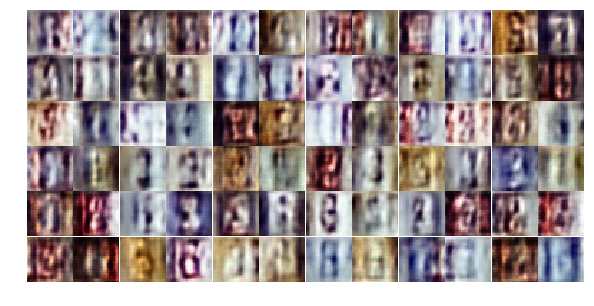

Epoch 3/25... Discriminator Loss: 0.5124... Generator Loss: 1.6702
Epoch 3/25... Discriminator Loss: 0.5782... Generator Loss: 1.9516
Epoch 3/25... Discriminator Loss: 1.1609... Generator Loss: 0.5485
Epoch 3/25... Discriminator Loss: 0.7438... Generator Loss: 1.2296
Epoch 4/25... Discriminator Loss: 0.5176... Generator Loss: 2.4771
Epoch 4/25... Discriminator Loss: 0.4714... Generator Loss: 1.5252
Epoch 4/25... Discriminator Loss: 0.5575... Generator Loss: 1.2482
Epoch 4/25... Discriminator Loss: 0.5987... Generator Loss: 2.0929
Epoch 4/25... Discriminator Loss: 0.4177... Generator Loss: 2.3582
Epoch 4/25... Discriminator Loss: 0.7300... Generator Loss: 1.0015


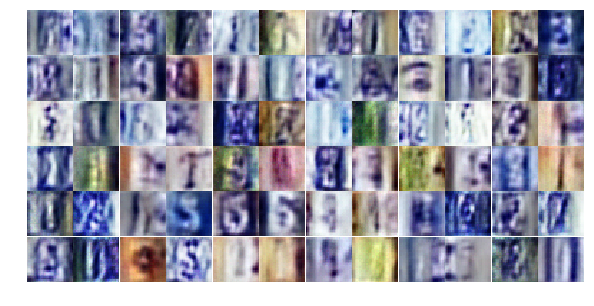

Epoch 4/25... Discriminator Loss: 0.4884... Generator Loss: 2.2244
Epoch 4/25... Discriminator Loss: 1.0544... Generator Loss: 0.6409
Epoch 4/25... Discriminator Loss: 0.4454... Generator Loss: 1.5725
Epoch 4/25... Discriminator Loss: 0.8562... Generator Loss: 2.5627
Epoch 4/25... Discriminator Loss: 0.7808... Generator Loss: 1.0879
Epoch 5/25... Discriminator Loss: 0.7201... Generator Loss: 0.9850
Epoch 5/25... Discriminator Loss: 0.3363... Generator Loss: 2.4620
Epoch 5/25... Discriminator Loss: 1.0606... Generator Loss: 0.6427
Epoch 5/25... Discriminator Loss: 1.0843... Generator Loss: 2.5075
Epoch 5/25... Discriminator Loss: 0.5584... Generator Loss: 1.3209


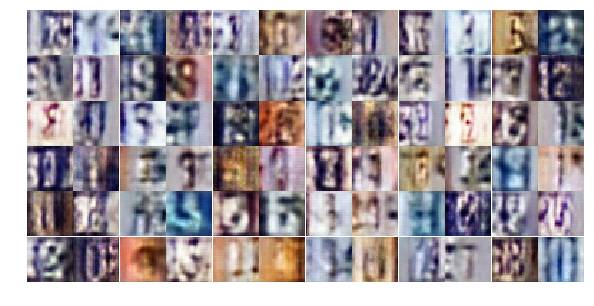

Epoch 5/25... Discriminator Loss: 0.6547... Generator Loss: 1.0232
Epoch 5/25... Discriminator Loss: 0.4905... Generator Loss: 1.3117
Epoch 5/25... Discriminator Loss: 0.8118... Generator Loss: 0.9604
Epoch 5/25... Discriminator Loss: 0.4132... Generator Loss: 1.8302
Epoch 5/25... Discriminator Loss: 0.5450... Generator Loss: 1.5722
Epoch 5/25... Discriminator Loss: 1.0978... Generator Loss: 3.0774
Epoch 5/25... Discriminator Loss: 0.4878... Generator Loss: 1.3283
Epoch 6/25... Discriminator Loss: 0.7148... Generator Loss: 0.8927
Epoch 6/25... Discriminator Loss: 1.0589... Generator Loss: 0.6106
Epoch 6/25... Discriminator Loss: 0.5665... Generator Loss: 1.9221


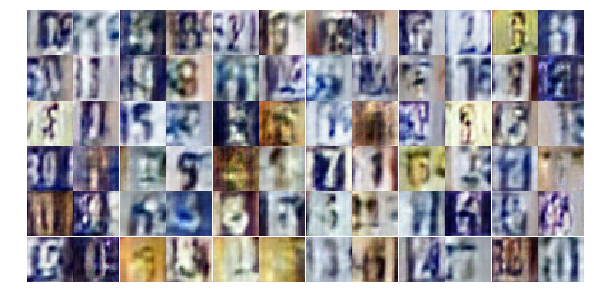

Epoch 6/25... Discriminator Loss: 0.5010... Generator Loss: 2.3135
Epoch 6/25... Discriminator Loss: 0.5767... Generator Loss: 1.3357
Epoch 6/25... Discriminator Loss: 0.8039... Generator Loss: 2.7508
Epoch 6/25... Discriminator Loss: 0.3909... Generator Loss: 1.7373
Epoch 6/25... Discriminator Loss: 0.6219... Generator Loss: 1.1827
Epoch 6/25... Discriminator Loss: 0.4055... Generator Loss: 1.7755
Epoch 6/25... Discriminator Loss: 0.4594... Generator Loss: 1.4435
Epoch 6/25... Discriminator Loss: 1.5723... Generator Loss: 0.3588
Epoch 7/25... Discriminator Loss: 0.6149... Generator Loss: 1.1355
Epoch 7/25... Discriminator Loss: 0.7602... Generator Loss: 1.1037


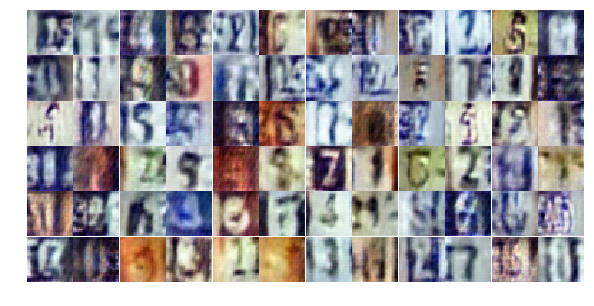

Epoch 7/25... Discriminator Loss: 0.4573... Generator Loss: 1.5676
Epoch 7/25... Discriminator Loss: 0.4447... Generator Loss: 2.1857
Epoch 7/25... Discriminator Loss: 0.4053... Generator Loss: 1.6725
Epoch 7/25... Discriminator Loss: 0.5092... Generator Loss: 1.7147
Epoch 7/25... Discriminator Loss: 0.6089... Generator Loss: 1.0859
Epoch 7/25... Discriminator Loss: 0.4438... Generator Loss: 1.9051
Epoch 7/25... Discriminator Loss: 0.9690... Generator Loss: 2.5540
Epoch 7/25... Discriminator Loss: 0.6472... Generator Loss: 1.1425
Epoch 7/25... Discriminator Loss: 0.5372... Generator Loss: 1.2111
Epoch 7/25... Discriminator Loss: 0.7737... Generator Loss: 0.8803


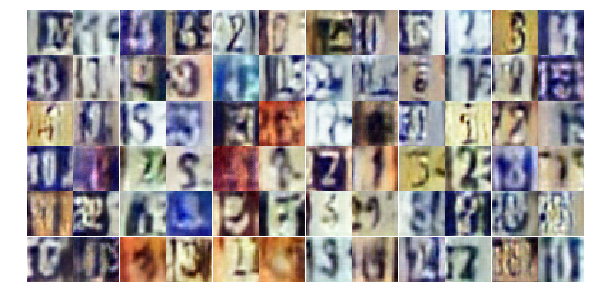

Epoch 8/25... Discriminator Loss: 0.4725... Generator Loss: 1.4464
Epoch 8/25... Discriminator Loss: 0.7103... Generator Loss: 0.9365
Epoch 8/25... Discriminator Loss: 1.0064... Generator Loss: 0.7484
Epoch 8/25... Discriminator Loss: 1.4315... Generator Loss: 0.3553
Epoch 8/25... Discriminator Loss: 0.3144... Generator Loss: 2.0182
Epoch 8/25... Discriminator Loss: 0.7919... Generator Loss: 1.2308
Epoch 8/25... Discriminator Loss: 1.3504... Generator Loss: 0.4127
Epoch 8/25... Discriminator Loss: 0.4931... Generator Loss: 1.4659
Epoch 8/25... Discriminator Loss: 1.5253... Generator Loss: 3.3469
Epoch 8/25... Discriminator Loss: 0.5545... Generator Loss: 1.5194


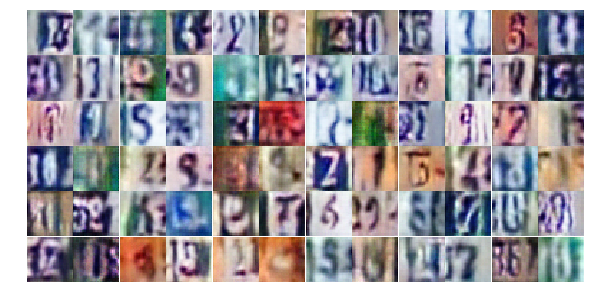

Epoch 8/25... Discriminator Loss: 0.5249... Generator Loss: 2.3345
Epoch 9/25... Discriminator Loss: 0.6942... Generator Loss: 0.8905
Epoch 9/25... Discriminator Loss: 1.2441... Generator Loss: 0.4850
Epoch 9/25... Discriminator Loss: 0.4897... Generator Loss: 2.1353
Epoch 9/25... Discriminator Loss: 0.5773... Generator Loss: 1.4044
Epoch 9/25... Discriminator Loss: 0.9187... Generator Loss: 0.6810
Epoch 9/25... Discriminator Loss: 0.4641... Generator Loss: 1.2773
Epoch 9/25... Discriminator Loss: 0.5356... Generator Loss: 1.1856
Epoch 9/25... Discriminator Loss: 0.8635... Generator Loss: 0.7393
Epoch 9/25... Discriminator Loss: 0.5126... Generator Loss: 1.2219


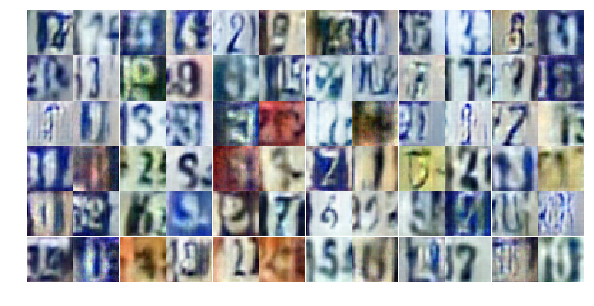

Epoch 9/25... Discriminator Loss: 0.5569... Generator Loss: 1.2229
Epoch 9/25... Discriminator Loss: 0.9474... Generator Loss: 3.0052
Epoch 9/25... Discriminator Loss: 0.5747... Generator Loss: 1.3945
Epoch 10/25... Discriminator Loss: 1.3153... Generator Loss: 0.4229
Epoch 10/25... Discriminator Loss: 0.6332... Generator Loss: 1.2479
Epoch 10/25... Discriminator Loss: 0.6695... Generator Loss: 1.1723
Epoch 10/25... Discriminator Loss: 0.6833... Generator Loss: 1.1053
Epoch 10/25... Discriminator Loss: 0.4762... Generator Loss: 2.0640
Epoch 10/25... Discriminator Loss: 1.0761... Generator Loss: 0.5632
Epoch 10/25... Discriminator Loss: 0.6856... Generator Loss: 1.0171


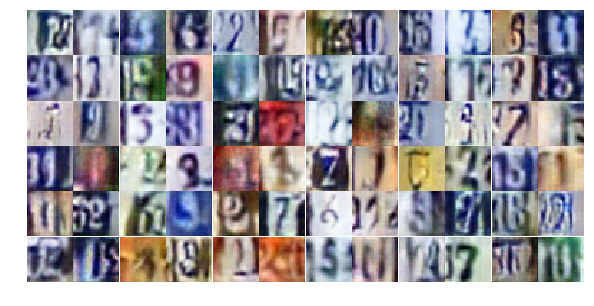

Epoch 10/25... Discriminator Loss: 0.6199... Generator Loss: 1.2593
Epoch 10/25... Discriminator Loss: 0.4685... Generator Loss: 1.9059
Epoch 10/25... Discriminator Loss: 0.4769... Generator Loss: 1.4798
Epoch 10/25... Discriminator Loss: 0.6470... Generator Loss: 1.1317
Epoch 11/25... Discriminator Loss: 0.6964... Generator Loss: 1.0123
Epoch 11/25... Discriminator Loss: 0.7011... Generator Loss: 1.0197
Epoch 11/25... Discriminator Loss: 0.6094... Generator Loss: 1.4511
Epoch 11/25... Discriminator Loss: 1.3657... Generator Loss: 0.4438
Epoch 11/25... Discriminator Loss: 0.3773... Generator Loss: 1.8983
Epoch 11/25... Discriminator Loss: 0.5247... Generator Loss: 1.9954


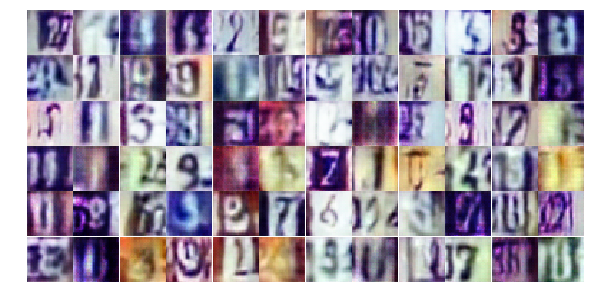

Epoch 11/25... Discriminator Loss: 0.6053... Generator Loss: 1.1651
Epoch 11/25... Discriminator Loss: 1.0732... Generator Loss: 0.5500
Epoch 11/25... Discriminator Loss: 0.7336... Generator Loss: 0.8980
Epoch 11/25... Discriminator Loss: 0.5669... Generator Loss: 1.2642
Epoch 11/25... Discriminator Loss: 1.4221... Generator Loss: 0.4216
Epoch 11/25... Discriminator Loss: 1.2856... Generator Loss: 0.4248
Epoch 12/25... Discriminator Loss: 0.5639... Generator Loss: 1.1301
Epoch 12/25... Discriminator Loss: 1.2499... Generator Loss: 0.4797
Epoch 12/25... Discriminator Loss: 0.4811... Generator Loss: 1.8337
Epoch 12/25... Discriminator Loss: 0.6092... Generator Loss: 1.1921


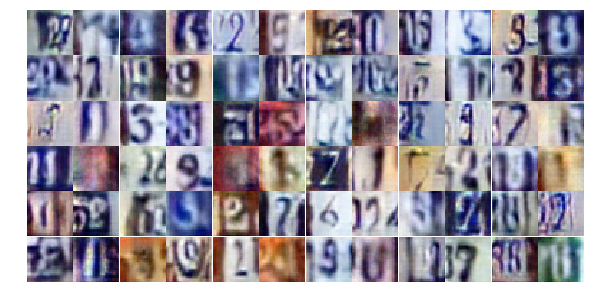

Epoch 12/25... Discriminator Loss: 0.4570... Generator Loss: 1.4427
Epoch 12/25... Discriminator Loss: 0.5797... Generator Loss: 1.1792
Epoch 12/25... Discriminator Loss: 0.6496... Generator Loss: 1.8521
Epoch 12/25... Discriminator Loss: 0.2710... Generator Loss: 2.0771
Epoch 12/25... Discriminator Loss: 1.6558... Generator Loss: 0.3636
Epoch 12/25... Discriminator Loss: 0.7246... Generator Loss: 0.9487
Epoch 12/25... Discriminator Loss: 0.4795... Generator Loss: 1.4718
Epoch 13/25... Discriminator Loss: 0.6567... Generator Loss: 1.0235
Epoch 13/25... Discriminator Loss: 0.6406... Generator Loss: 1.0672
Epoch 13/25... Discriminator Loss: 0.4213... Generator Loss: 1.6627


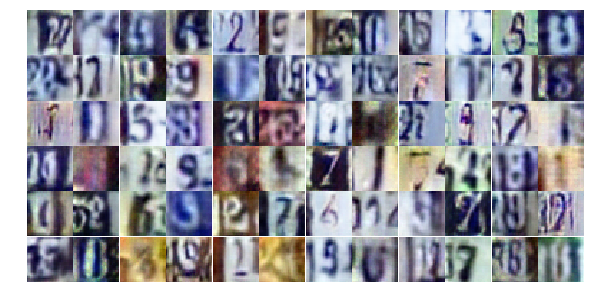

Epoch 13/25... Discriminator Loss: 1.5485... Generator Loss: 0.8443
Epoch 13/25... Discriminator Loss: 1.0510... Generator Loss: 0.5890
Epoch 13/25... Discriminator Loss: 0.9219... Generator Loss: 0.7013
Epoch 13/25... Discriminator Loss: 0.5266... Generator Loss: 1.5837
Epoch 13/25... Discriminator Loss: 0.4813... Generator Loss: 1.3921
Epoch 13/25... Discriminator Loss: 0.7196... Generator Loss: 0.8800
Epoch 13/25... Discriminator Loss: 3.9798... Generator Loss: 5.7384
Epoch 13/25... Discriminator Loss: 0.8751... Generator Loss: 0.8368
Epoch 14/25... Discriminator Loss: 0.7627... Generator Loss: 0.9736
Epoch 14/25... Discriminator Loss: 0.6771... Generator Loss: 1.0348


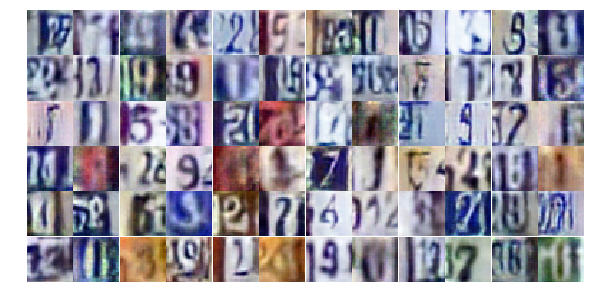

Epoch 14/25... Discriminator Loss: 0.8899... Generator Loss: 0.7071
Epoch 14/25... Discriminator Loss: 1.6380... Generator Loss: 0.3216
Epoch 14/25... Discriminator Loss: 0.7627... Generator Loss: 0.9074
Epoch 14/25... Discriminator Loss: 0.5019... Generator Loss: 1.5611
Epoch 14/25... Discriminator Loss: 0.4511... Generator Loss: 1.6313
Epoch 14/25... Discriminator Loss: 0.7020... Generator Loss: 1.0120
Epoch 14/25... Discriminator Loss: 1.1508... Generator Loss: 0.4867
Epoch 14/25... Discriminator Loss: 1.3579... Generator Loss: 0.4244
Epoch 14/25... Discriminator Loss: 0.6990... Generator Loss: 1.0736
Epoch 14/25... Discriminator Loss: 1.4863... Generator Loss: 0.3721


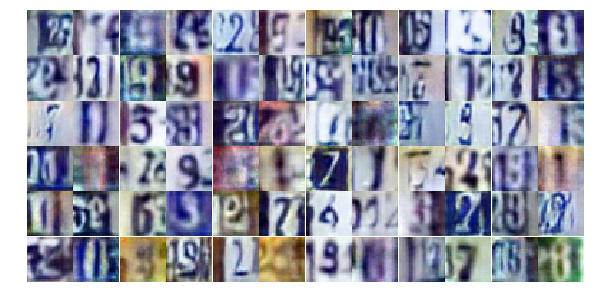

Epoch 15/25... Discriminator Loss: 0.6340... Generator Loss: 1.1014
Epoch 15/25... Discriminator Loss: 0.5880... Generator Loss: 1.0749
Epoch 15/25... Discriminator Loss: 0.9785... Generator Loss: 0.6752
Epoch 15/25... Discriminator Loss: 0.8903... Generator Loss: 0.8150
Epoch 15/25... Discriminator Loss: 0.9696... Generator Loss: 0.6910
Epoch 15/25... Discriminator Loss: 1.5957... Generator Loss: 0.3045
Epoch 15/25... Discriminator Loss: 0.8369... Generator Loss: 0.8732
Epoch 15/25... Discriminator Loss: 0.7321... Generator Loss: 0.9592
Epoch 15/25... Discriminator Loss: 0.6366... Generator Loss: 1.0474
Epoch 15/25... Discriminator Loss: 0.7162... Generator Loss: 1.2208


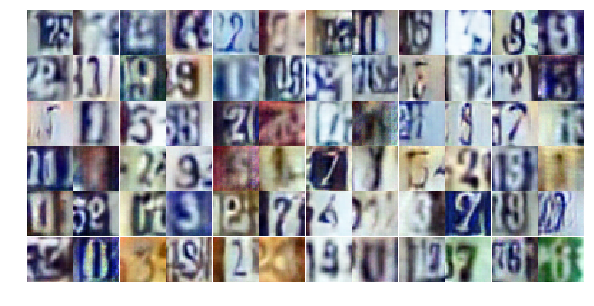

Epoch 15/25... Discriminator Loss: 1.7486... Generator Loss: 1.1557
Epoch 16/25... Discriminator Loss: 1.0094... Generator Loss: 0.6345
Epoch 16/25... Discriminator Loss: 0.5419... Generator Loss: 1.3929
Epoch 16/25... Discriminator Loss: 0.5625... Generator Loss: 1.1188
Epoch 16/25... Discriminator Loss: 2.0210... Generator Loss: 0.2848
Epoch 16/25... Discriminator Loss: 0.6246... Generator Loss: 1.0969
Epoch 16/25... Discriminator Loss: 0.9695... Generator Loss: 0.7049
Epoch 16/25... Discriminator Loss: 0.7075... Generator Loss: 1.2215
Epoch 16/25... Discriminator Loss: 0.8732... Generator Loss: 0.8232
Epoch 16/25... Discriminator Loss: 0.5788... Generator Loss: 1.1191


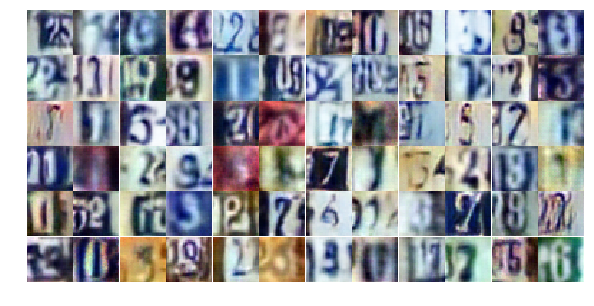

Epoch 16/25... Discriminator Loss: 0.5442... Generator Loss: 1.7595
Epoch 16/25... Discriminator Loss: 0.9919... Generator Loss: 0.7171
Epoch 16/25... Discriminator Loss: 0.4821... Generator Loss: 1.3160
Epoch 17/25... Discriminator Loss: 0.5508... Generator Loss: 1.9761
Epoch 17/25... Discriminator Loss: 1.0040... Generator Loss: 0.6687
Epoch 17/25... Discriminator Loss: 0.7083... Generator Loss: 1.9444
Epoch 17/25... Discriminator Loss: 0.5389... Generator Loss: 1.3447
Epoch 17/25... Discriminator Loss: 0.5373... Generator Loss: 1.3289
Epoch 17/25... Discriminator Loss: 1.9625... Generator Loss: 0.2272
Epoch 17/25... Discriminator Loss: 0.4125... Generator Loss: 1.6365


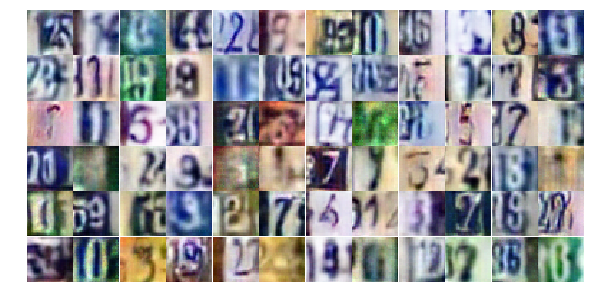

Epoch 17/25... Discriminator Loss: 0.7298... Generator Loss: 1.0429
Epoch 17/25... Discriminator Loss: 1.2604... Generator Loss: 0.4667
Epoch 17/25... Discriminator Loss: 1.5050... Generator Loss: 0.3643
Epoch 17/25... Discriminator Loss: 1.2009... Generator Loss: 0.5701
Epoch 18/25... Discriminator Loss: 0.6386... Generator Loss: 1.1986
Epoch 18/25... Discriminator Loss: 0.6226... Generator Loss: 1.3228
Epoch 18/25... Discriminator Loss: 0.5626... Generator Loss: 1.2732
Epoch 18/25... Discriminator Loss: 0.4506... Generator Loss: 1.5883
Epoch 18/25... Discriminator Loss: 1.0666... Generator Loss: 0.6218
Epoch 18/25... Discriminator Loss: 0.6814... Generator Loss: 1.1304


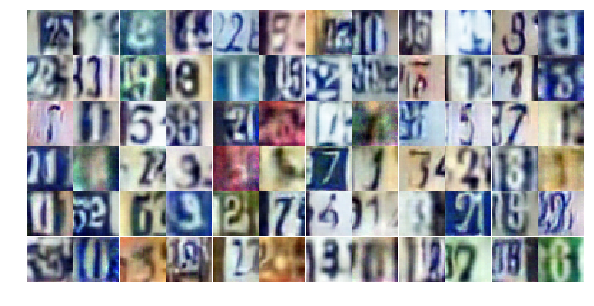

Epoch 18/25... Discriminator Loss: 0.9739... Generator Loss: 0.7612
Epoch 18/25... Discriminator Loss: 0.8396... Generator Loss: 0.7887
Epoch 18/25... Discriminator Loss: 1.0080... Generator Loss: 0.6273
Epoch 18/25... Discriminator Loss: 0.3852... Generator Loss: 1.6613
Epoch 18/25... Discriminator Loss: 0.8191... Generator Loss: 0.9263
Epoch 18/25... Discriminator Loss: 0.5310... Generator Loss: 1.8597
Epoch 19/25... Discriminator Loss: 0.7813... Generator Loss: 0.9246
Epoch 19/25... Discriminator Loss: 0.9957... Generator Loss: 0.7589
Epoch 19/25... Discriminator Loss: 0.9164... Generator Loss: 0.7528
Epoch 19/25... Discriminator Loss: 1.2972... Generator Loss: 0.5969


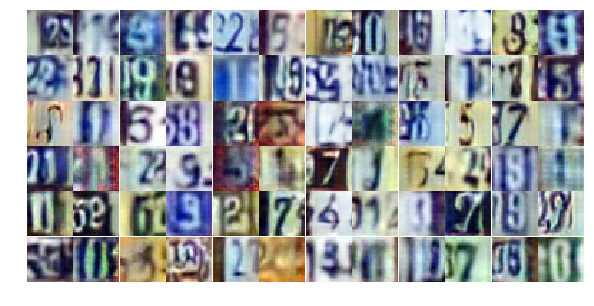

Epoch 19/25... Discriminator Loss: 1.0594... Generator Loss: 0.6449
Epoch 19/25... Discriminator Loss: 1.0679... Generator Loss: 0.6067
Epoch 19/25... Discriminator Loss: 0.5991... Generator Loss: 1.3306
Epoch 19/25... Discriminator Loss: 0.6626... Generator Loss: 0.9373
Epoch 19/25... Discriminator Loss: 0.7676... Generator Loss: 1.4059
Epoch 19/25... Discriminator Loss: 0.8092... Generator Loss: 0.9846
Epoch 19/25... Discriminator Loss: 0.6355... Generator Loss: 1.8055
Epoch 20/25... Discriminator Loss: 1.0128... Generator Loss: 0.6915
Epoch 20/25... Discriminator Loss: 0.5915... Generator Loss: 1.2204
Epoch 20/25... Discriminator Loss: 0.7671... Generator Loss: 0.8096


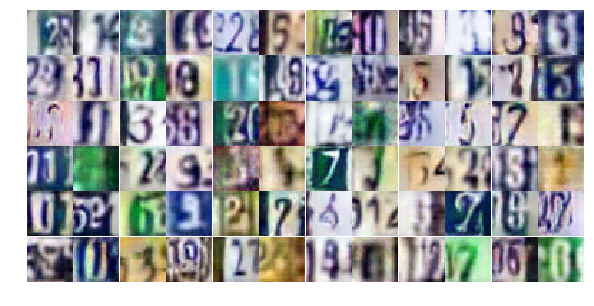

Epoch 20/25... Discriminator Loss: 0.9647... Generator Loss: 0.7217
Epoch 20/25... Discriminator Loss: 0.9555... Generator Loss: 0.6927
Epoch 20/25... Discriminator Loss: 1.1517... Generator Loss: 0.5623
Epoch 20/25... Discriminator Loss: 0.6301... Generator Loss: 1.7605
Epoch 20/25... Discriminator Loss: 0.9669... Generator Loss: 0.6954
Epoch 20/25... Discriminator Loss: 1.1388... Generator Loss: 0.5893
Epoch 20/25... Discriminator Loss: 1.7116... Generator Loss: 0.3281
Epoch 20/25... Discriminator Loss: 0.5233... Generator Loss: 1.3464
Epoch 20/25... Discriminator Loss: 0.9573... Generator Loss: 0.6956
Epoch 21/25... Discriminator Loss: 1.1353... Generator Loss: 0.5565


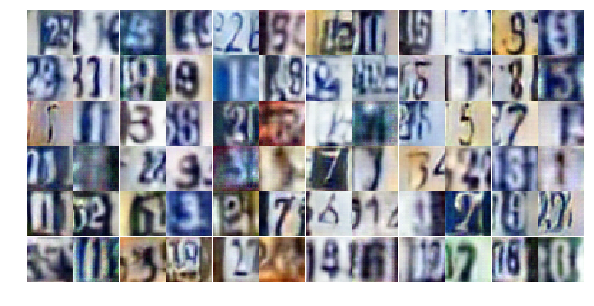

Epoch 21/25... Discriminator Loss: 0.8892... Generator Loss: 0.7262
Epoch 21/25... Discriminator Loss: 1.3123... Generator Loss: 0.4470
Epoch 21/25... Discriminator Loss: 0.6363... Generator Loss: 1.2232
Epoch 21/25... Discriminator Loss: 0.9130... Generator Loss: 0.7583
Epoch 21/25... Discriminator Loss: 1.0204... Generator Loss: 0.6540
Epoch 21/25... Discriminator Loss: 1.3586... Generator Loss: 0.4677
Epoch 21/25... Discriminator Loss: 0.4787... Generator Loss: 1.3639
Epoch 21/25... Discriminator Loss: 0.2356... Generator Loss: 3.2841
Epoch 21/25... Discriminator Loss: 0.4304... Generator Loss: 1.6131
Epoch 21/25... Discriminator Loss: 0.6264... Generator Loss: 1.1006


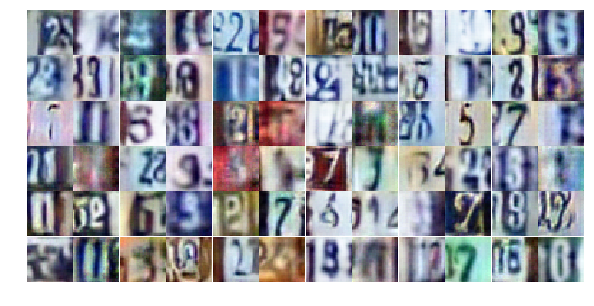

Epoch 22/25... Discriminator Loss: 0.7373... Generator Loss: 1.5926
Epoch 22/25... Discriminator Loss: 0.6570... Generator Loss: 1.1102
Epoch 22/25... Discriminator Loss: 0.6838... Generator Loss: 1.3884
Epoch 22/25... Discriminator Loss: 2.0236... Generator Loss: 0.2159
Epoch 22/25... Discriminator Loss: 0.4706... Generator Loss: 1.6178
Epoch 22/25... Discriminator Loss: 0.8746... Generator Loss: 0.8103
Epoch 22/25... Discriminator Loss: 1.1363... Generator Loss: 0.5399
Epoch 22/25... Discriminator Loss: 1.4041... Generator Loss: 0.3901
Epoch 22/25... Discriminator Loss: 0.4394... Generator Loss: 1.3489
Epoch 22/25... Discriminator Loss: 0.7128... Generator Loss: 1.0169


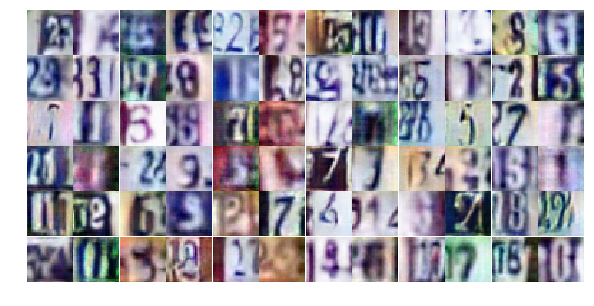

Epoch 22/25... Discriminator Loss: 0.8027... Generator Loss: 1.5554
Epoch 22/25... Discriminator Loss: 0.8445... Generator Loss: 0.7965
Epoch 23/25... Discriminator Loss: 0.6037... Generator Loss: 1.2007
Epoch 23/25... Discriminator Loss: 0.4395... Generator Loss: 1.3735
Epoch 23/25... Discriminator Loss: 0.7180... Generator Loss: 0.9670
Epoch 23/25... Discriminator Loss: 0.7932... Generator Loss: 0.8408
Epoch 23/25... Discriminator Loss: 0.3725... Generator Loss: 1.8392
Epoch 23/25... Discriminator Loss: 1.2355... Generator Loss: 2.3484
Epoch 23/25... Discriminator Loss: 0.9107... Generator Loss: 0.8572
Epoch 23/25... Discriminator Loss: 0.5831... Generator Loss: 1.1638


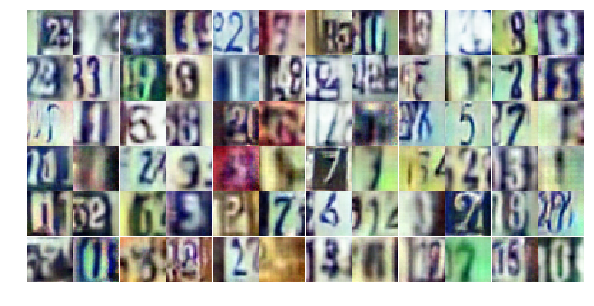

Epoch 23/25... Discriminator Loss: 1.6591... Generator Loss: 0.3178
Epoch 23/25... Discriminator Loss: 0.9788... Generator Loss: 0.8950
Epoch 23/25... Discriminator Loss: 1.1660... Generator Loss: 0.6191
Epoch 24/25... Discriminator Loss: 0.9686... Generator Loss: 0.8074
Epoch 24/25... Discriminator Loss: 0.5048... Generator Loss: 3.5655
Epoch 24/25... Discriminator Loss: 0.4045... Generator Loss: 2.0091
Epoch 24/25... Discriminator Loss: 0.4313... Generator Loss: 1.8958
Epoch 24/25... Discriminator Loss: 0.6408... Generator Loss: 1.2285
Epoch 24/25... Discriminator Loss: 0.5466... Generator Loss: 1.1596
Epoch 24/25... Discriminator Loss: 0.8546... Generator Loss: 0.8236


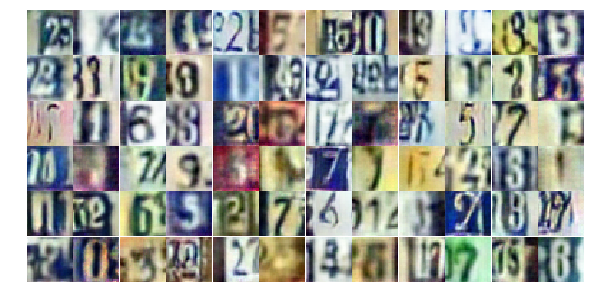

Epoch 24/25... Discriminator Loss: 1.3455... Generator Loss: 0.4704
Epoch 24/25... Discriminator Loss: 0.5449... Generator Loss: 1.7698
Epoch 24/25... Discriminator Loss: 1.3835... Generator Loss: 0.4821
Epoch 24/25... Discriminator Loss: 0.7319... Generator Loss: 1.9261
Epoch 24/25... Discriminator Loss: 0.9221... Generator Loss: 0.7279
Epoch 25/25... Discriminator Loss: 0.9484... Generator Loss: 0.7868
Epoch 25/25... Discriminator Loss: 0.7535... Generator Loss: 1.6720
Epoch 25/25... Discriminator Loss: 1.0427... Generator Loss: 0.6932
Epoch 25/25... Discriminator Loss: 0.7169... Generator Loss: 0.9963
Epoch 25/25... Discriminator Loss: 1.4777... Generator Loss: 0.4424


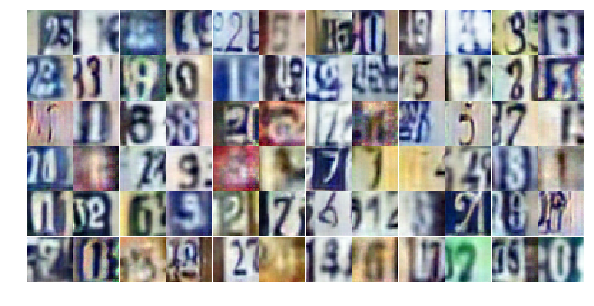

Epoch 25/25... Discriminator Loss: 0.6770... Generator Loss: 0.9950
Epoch 25/25... Discriminator Loss: 0.4487... Generator Loss: 1.7450
Epoch 25/25... Discriminator Loss: 1.1702... Generator Loss: 0.5820
Epoch 25/25... Discriminator Loss: 0.5196... Generator Loss: 1.6640
Epoch 25/25... Discriminator Loss: 0.7919... Generator Loss: 1.0334
Epoch 25/25... Discriminator Loss: 0.9013... Generator Loss: 0.7540


In [29]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, print_every=50, show_every=500, figsize=(10,5))

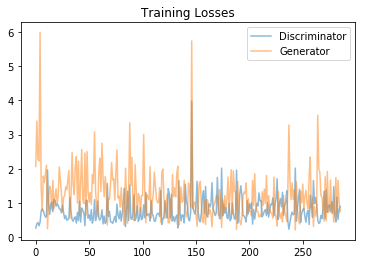

In [30]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

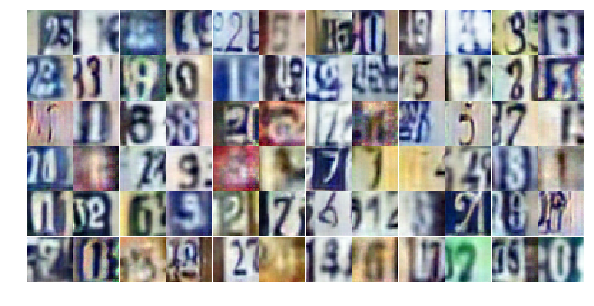

In [31]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))